# Оптимальная аппроксимация сплайнами
### Матвей Морозов

# Постановка задачи
1) Дана выборка точек $$\Large {\{x_i \in \mathbb{R}^d, y_i \in \mathbb{R}^1 \}_{i=1}^{n}}$$

2) $$\Large {y_i= f_0(x_i) + \xi_i}$$, где $\xi_i$ - гауссовский шум


## Необходимо:
Построить функцию $$\Large{\hat{f}: \mathbb{R}^d \rightarrow \mathbb{R}^1}$$, которая хорошо приближает данные обучающей выборки.

# В ходе решения задачи:
1) Были найдены коэффициенты разложения по конечномерному базису для приближающей функции;

2) Был реализован алгоритм нахождения сглаживающего сплайна;

3) Был придуман и реализован алгоритм нахождения коэффициентов разложения за указанное время;

$$\Large{\{x_i \in \mathbb{R}, y_i \in \mathbb{R}^1 \}_{i=1}^{n}}$$
$$\Large{\hat{f}: \mathbb{R}^d \rightarrow \mathbb{R}^1}$$




Подобная задача сводится к поиску коэффициентов разложения по конечномерному базису $\{\psi_j\}_{j=1}^{n}$
        $$\Large{f(x) = \sum_{i=1}^{n} \alpha_i \psi_i}$$

# Сглаживающие сплайны
$$\Large{\hat{f} = argmin_f{\alpha} (\sum_{i=1}^{n} (y_i - f(x_i))^2 + \lambda \int (\cfrac{d^2f}{dx^2})^2)}$$

Подобная задача сводится к поиску коэффициентов разложения по конечномерному базису $\{\psi_j\}_{j=1}^{n}$

Необходимо решить задачу квадратичной оптимизации

$$\Large{\hat{f} = argmin_{\alpha} (\sum_{i=1}^{n} (y_i - \alpha^{T}\psi_i)^2 + \lambda \alpha^{T} \Omega \alpha)}$$



1) матрицы $\psi$ - это $n \times p$ матрица значений базисных функций в точках выборки, $\psi|_{i,j} = \psi_j(x_i)$,

2)  $p$ - число этих базисных функций,

3) $\psi_i$ - одна строк матрицы $\psi$,

4) $\Omega$ - симметричная положительно определённая $p \times p$ матрица, состоящая из скалярных произведений вторых производных базисных функций.

In [104]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Определим функцию B-сплайна

$$\Large{
B_{i,0} (x) := \begin{cases}
1 \ \ if \ \ t_i < x < t_{i+1} \\
0 \ \ otherwise
\end{cases}}
$$
        
$$\Large{B_{i,k} (x) := \cfrac{x - t_i}{t_{i+k} - t_i} B_{i,k-1}(x) + \cfrac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}}B_{i,k+1}(x)}
    $$

In [105]:
def B(x, k, i, t):
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2


## Пример системы линейных базисных сплайнов

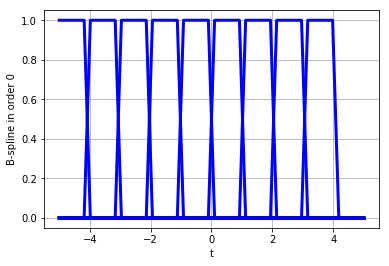

In [106]:
k = 0
t = [-7,-6,-5,-4,-3,-2,-1 ,0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

xx = np.linspace(-5, 5, 50)

fig, ax = plt.subplots()

for i in range (11):
    ax.plot(xx, [B(x, k, i ,t) for x in xx], 'blue', lw=3)

plt.xlabel('t')
plt.ylabel('B-spline in order 0')
ax.grid(True)  
plt.show()

## Пример системы кубических B-сплайнов

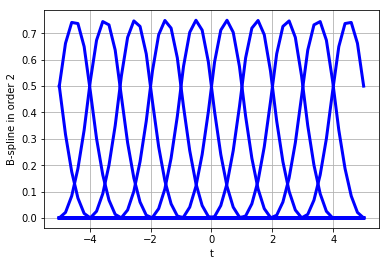

In [107]:
k = 2
fig, ax = plt.subplots()

for i in range (11):
    ax.plot(xx, [B(x, k, i ,t) for x in xx], 'blue', lw=3)
plt.xlabel('t')
plt.ylabel('B-spline in order 2')
ax.grid(True) 
plt.show()

# Коэффициенты разложения по B-spline

$$\Large{\hat{f} = argmin_{\alpha} (\sum_{i=1}^{n} (y_i - \alpha^{T}\psi_i)^2 + \lambda \alpha^{T} \Omega \alpha)}$$

Как будет показано дальше, что коэффициенты разложения будут иметь вид:
$\Large{\alpha_{\lambda} = (\psi^{T} \psi + \lambda \Omega)^{-1} \psi^{T} y}$

In [108]:
from scipy.misc import derivative #импортировали библиотеку для нахождения производной функции в точке

### Определим функцию, которая считает коэффициенты разложения по B-сплайнам
$$\Large{f(x) = \sum_{i=1}^{n} \alpha_i B_{i,k}}$$

### Также определим функцию, которая находит искомый сглаживающий сплайн

In [109]:
# m - число точек выборки
# p - число базисных функций (B-сплайнов), которыми мы будем искать приближение
# m - степень полинома B-сплайна
# lam - параметр сглаживания

#функция, вычисляющая коэффициенты
def spline (n, p, m, lam):
    M = [0] * n 
    for i in range(n): 
        M[i] = [0] * p

    #задали матрицу базисных функций
    for i in range (n):
        for k in range (p):
            M[i][k] = B(x[i],m,k, t)

    G = [0] * n 
    for i in range(n): 
        G[i] = [0] * p

    for i in range (n):
        for k in range (p):
            def j(x):
                return B(x,m,k,t)
            G[i][k] = derivative (j,x[i],dx=1e-6,n=2)

    H = np.transpose(G)

    C = [0] * p
    for i in range(p): 
        C[i] = [0] * p

    #вычислили матрицу вторых производных
    for i in range (p):
        for k in range (p):
            C[i][k]= np.dot(H[i],H[k])
   
    #посчитали вектор коэффициентов, с которыми мы будем брать B-сплайны
    S = np.dot (np.dot (np.linalg.inv(np.dot(np.transpose (M),M) + np.dot (lam, C)), np.transpose (M)), y)
    return S

#искомая функция
def f(x):
    l = 0
    for i in range (p):
        l = l + S[i]* B(x, m, i, t)
    return l

### Построим как пример $sin(x)$

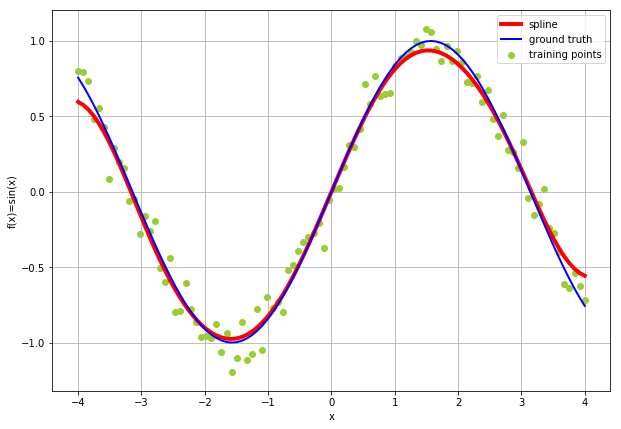

In [110]:
n=100
p = 9
m= 5
lam = 0.025

xx = np.linspace(-4, 4, 100)
x = np.linspace(-4, 4, 100)

#настоящая функция
def g(x):
    return np.sin(x)

#генерация данных с шумами
y = g(x) + np.random.normal(0,1,100)*0.1

S = spline (n, p, m, lam)
fig, ax = plt.subplots(figsize=[10, 7])

plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
ax.plot(xx, [f(x) for x in xx], 'red', lw=4, label = 'spline')
ax.plot (xx, [g(x) for x in xx], 'blue', lw=2, label = "ground truth")
plt.xlabel('x')
plt.ylabel('f(x)=sin(x)')
ax.grid(True)
plt.legend(loc='best')

# Коэффициент сглаживания

Посмотрим, как будет вести себя сплайн-функция в зависимости о коэффициента сглаживания $\lambda$.

### Функция $\arctan (x)$
### Хорошо подобранный коэффициент сглаживания

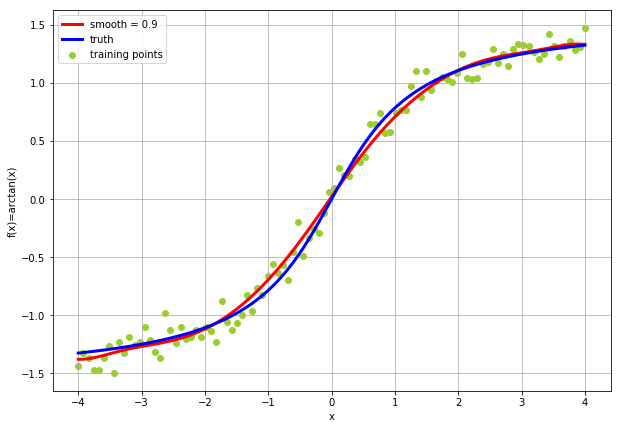

In [111]:
#настоящая функция
def g(x):
    return np.arctan(x)

xx = np.linspace(-4, 4, 100)
x = np.linspace(-4, 4, 100)

n=100
p = 10
m= 4
lam = 0.09


#генерация данных с шумами
y = g(x) + np.random.normal(0,1,100)*0.1

fig, ax = plt.subplots(figsize=[10, 7])
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
S = spline (n, p, m, lam)
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'smooth = 0.9')
ax.plot(xx, [g(x) for x in xx], 'blue', lw=3, label = 'truth')
plt.xlabel('x')
plt.ylabel('f(x)=arctan(x)')
plt.legend(loc='best')
ax.grid(True)


### $\lambda = 0$
### Отсутствие сглаживаня. Сглаживающий сплайн превращается в интерполяционный сплайн

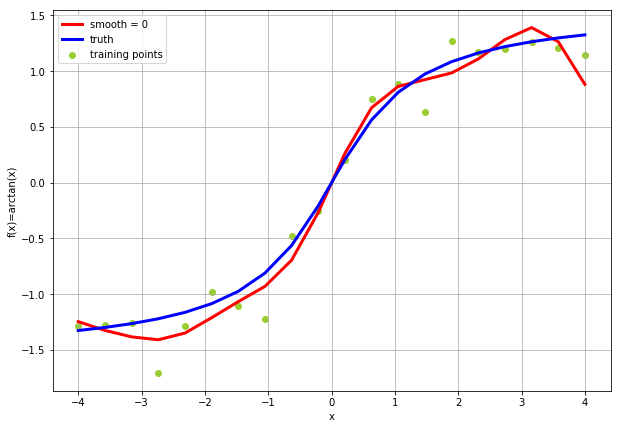

In [112]:
def g(x):
    return np.arctan(x)
xx = np.linspace(-4, 4, 20)
x = np.linspace(-4, 4, 20)
n=20
p = 9
m= 4
lam = 0
y = g(x) + np.random.normal(0,1,20)*0.2
fig, ax = plt.subplots(figsize=[10, 7])
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
S = spline (n, p, m, lam)
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'smooth = 0')
ax.plot(xx, [g(x) for x in xx], 'blue', lw=3, label = 'truth')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('f(x)=arctan(x)')
ax.grid(True)

### Бесконечное сглаживание ($\lambda = \infty$). Сплайн превращается в МНК аппкроксимацию

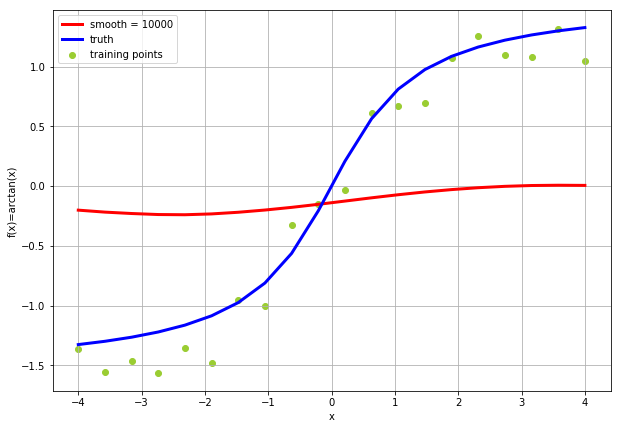

In [113]:
xx = np.linspace(-4, 4, 20)
x = np.linspace(-4, 4, 20)
n=20
p = 9
m= 4
lam = 100
y = g(x) + np.random.normal(0,1,20)*0.2
fig, ax = plt.subplots(figsize=[10, 7])
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
S = spline (n, p, m, lam)
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'smooth = 10000')
ax.plot(xx, [g(x) for x in xx], 'blue', lw=3, label = 'truth')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('f(x)=arctan(x)')
ax.grid(True)

# Примеры построения сплайн-функций

## $x \cdot \sin(x)$

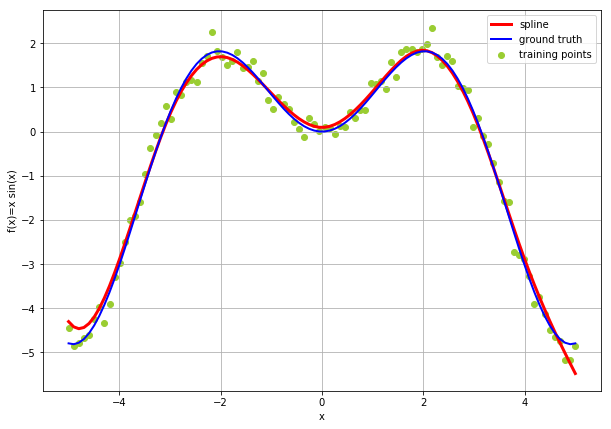

In [114]:
#настоящая функция
def g(x):
    return x*np.sin(x)

xx = np.linspace(-5, 5, 100)
x = np.linspace(-5, 5, 100)
n=100
p =12
m= 3
lam = 0.025
#генерация данных с шумами
y = g(x) + np.random.normal(0,1,100)*0.2
fig, ax = plt.subplots(figsize=[10, 7])
S = spline (n, p, m, lam)
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'spline')
ax.plot (xx, [g(x) for x in xx], 'blue', lw=2, label = "ground truth")
ax.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)=x sin(x)')
plt.legend(loc='best')

## $\exp (-x^2) \cdot \sin(x)$

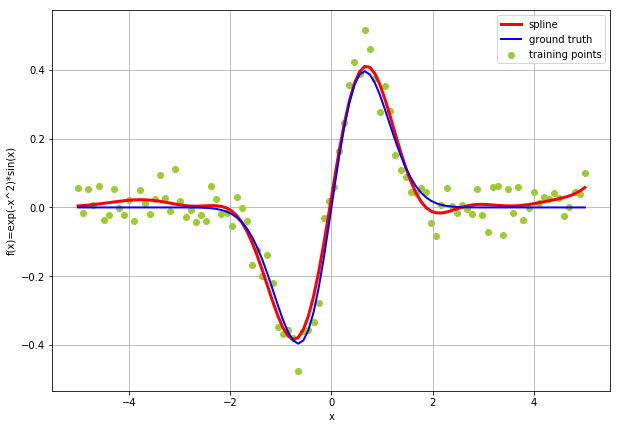

In [115]:
#настоящая функция
def g(x):
    return np.exp(-x**2)*np.sin(x)

xx = np.linspace(-5, 5, 100)
x = np.linspace(-5, 5, 100)
n=100
p =12
m= 4
lam = 0.0025
#генерация данных с шумами
y = g(x) + np.random.normal(0,1,100)*0.05
fig, ax = plt.subplots(figsize=[10, 7])
S = spline (n, p, m, lam)
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'spline')
ax.plot (xx, [g(x) for x in xx], 'blue', lw=2, label = "ground truth")
ax.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)=exp(-x^2)*sin(x)')
plt.legend(loc='best')

# Необходимо: 
## доказать корректность формулы

$$\Large{\alpha_{\lambda} = (\psi^{T} \psi + \lambda \Omega)^{-1} \psi^{T} y}$$
и предложить алгоритм вычисления коэффициентов разложения $\alpha_{\lambda}$ для набора значений $\lambda$, который на этапе инициализации требует $O(np^2 + p^3)$ операций, а затем для каждого параметра регуляризации $\lambda$ всего $O(p^2)$ операций.

# Доказательство корректности формулы

1) Наша задача найти коэффициенты разложения, при которых функция
$$\Large{g = \sum_{i=1}^{n} (y_i - \alpha^{T}\psi_i)^2 + \lambda \alpha^{T} \Omega \alpha}$$
принимает минимальное значение.

2) Перезапишем функцию $g$ в виде
$$\Large {g = (y - \psi \alpha)^{T} (y - \psi \alpha) + \lambda \alpha^{T} \Omega \alpha}$$

3) Продиффиринцируем нашу функцию $g$ по параметру $\alpha$.

4) $$\Large{g' = (y^Ty - y^T\psi \alpha - \alpha^T\psi^T y + \alpha^T \psi^T \psi \alpha + \lambda \alpha^{T} \Omega \alpha)' = 0}$$
так как мы рассматриваем минимум функции.

По правилу дифферинцирования матриц:
	$$\Large{\cfrac{d(y^Ty)}{d \alpha} = 0}$$
	$$\Large{\cfrac{d(y^T\psi \alpha)}{d \alpha} = \cfrac{d(\alpha^T\psi^T y)}{d \alpha} = \psi^T y}$$
	$$\Large{\cfrac{d(\alpha^T \psi^T \psi \alpha)}{d \alpha} = 2 \psi^T \psi \alpha}$$
	$$\Large{\cfrac{d(\lambda \alpha^{T} \Omega \alpha)}{d \alpha} = 2 \lambda \Omega \alpha}$$
    

Получим:
$$\Large{-\psi^T y + \psi^T \psi \alpha + \lambda \Omega \alpha = 0}$$

$$\Large{\psi^T \psi \alpha + \lambda \Omega \alpha = \psi^T y}$$

$$\Large{\psi^T \psi + \lambda \Omega) \alpha = \psi^T y}$$

Домножим на $\Large{(\psi^T \psi + \lambda \Omega)^{-1}}$

Получим необходимую формулу:
$$\Large{\alpha_{\lambda} = (\psi^{T} \psi + \lambda \Omega)^{-1} \psi^{T} y}$$

5) Это заканчивает доказательство корректности этой формулы.

# Алгоритм

1) Как мы знаем, матрицы $\psi^T \psi$ и $\Omega$ являются симметричными положительными матрицами. Это значит, что существует такая невырожденная матрица $X$, что справедливо
	$$\Large{X^T \psi^T \psi X = D_A}$$
	$$\Large{X^T \Omega  X = D_B}$$
	где $D_A$ и $D_B$ диагональные.
	
Далее матрицы $\psi^T \psi$ и $\Omega$ я буду обозначать как $A$ и $B$ соответственно.
	
Кроме того известно, что $$\Large{\lambda_i Ax_i = B x_i}$$ где $x_i$ - $i$-ый столбец матрицы $X$, $$\Large{\lambda_i = \frac{d_i^b}{d_i^a}}$$

2) 
## Рассмотрим выражение 

1) $$\Large{(A + \lambda B)x_i = (A + \lambda \cdot \lambda_i A)x_i = (1+\lambda \cdot \lambda_i)Ax_i}$$

2) $$\Large{(A+\lambda B)X = A\cdot X \cdot M}$$

$$\Large{M_i = \lambda \lambda_i + 1}$$

3) $$\Large{X^T \cdot (A+\lambda B)X = X^T A X \cdot M = D_A \cdot M}$$

4) $$\Large{(X^T \cdot (A+\lambda B)X)^{-1} = X^{-1} (A+\lambda B)^{-1} (X^T)^{-1}}$$

5) $$\Large{(A+ \lambda B)^{-1} = X \cdot (D_A \cdot M)^{-1} X^T}$$
		
## Получим:

$$\Large{\alpha_{\lambda} = X (D_A \cdot M)^{-1} X^T \psi^{T} y}$$

$$\Large{(D_A \cdot M)^{-1}_i =  d_i^a \cdot (\lambda \lambda_i + 1))^{-1} }$$

# Что необходимо:

### 1) Найти базис (матрица  $\Large{X}$), в котором обе матрицы $\Large{\psi^T \psi, \Omega}$ имеют диагональный вид. Можно сделать за $\Large{O(p^3)}$

### 2) Найти столбец $$\Large{X^T \psi^{T} y}$$ высоты p за $\Large{O(np^2)}$

### 3) Вычислить элементы матрицы $\Large{(D_A \cdot M)^{-1}}$ за $\Large{O(p)}$

### 4) Найти произведение $\Large{X (D_A \cdot M)^{-1}}$ за $\Large{O(p^2)}$

### 5) Умножить $\Large{X (D_A \cdot M)^{-1}}$ на $$\Large{X^T \psi^{T} y}$$ за $\Large{O(p^2)}$

# Реализация моего алгоритма

In [116]:
import scipy as sp

def myspline(n,p,m):    
    #задали матрицу базисных функций
    M = [0] * n 
    for i in range(n): 
        M[i] = [0] * p
        
    #заполнили её значениями базисных функций в точках
    for i in range (n):
        for k in range (p):
            M[i][k] = B(x[i],m,k, t)

    G = [0] * n 
    for i in range(n): 
        G[i] = [0] * p

    #создали и заполнили матрицу 2-х производных
    for i in range (n):
        for k in range (p):
            def j(x):
                return B(x,m,k,t)
            G[i][k] = derivative (j,x[i],dx=1e-6,n=2)

    H = np.transpose(G)

    C = [0] * p
    for i in range(p): 
        C[i] = [0] * p

    #вычислили матрицу вторых производных
    for i in range (p):
        for k in range (p):
            C[i][k]= np.dot(H[i],H[k])

    H = np.dot(np.transpose (M),M)
    
    #нашли базис v, в котором обе матрицы имеют диагональный вид
    w,v = sp.linalg.eig(C,H) 
    L = np.dot(np.dot (np.transpose(v),C),v)
    J = np.dot(np.dot (np.transpose(v),np.dot(np.transpose (M),M)),v)

    s=[0]*p
    f=[0]*p

    for i in range (p):
        s[i]= L[i][i] #D_b
        f[i]= J[i][i] #D_a

    V = np.dot(np.dot(np.transpose (v), np.transpose (M)), y)
    
    return [v,f,s,V]

def spl():
    Z = [0] * p 
    for i in range(p): 
        Z[i] = [0] * p
        
    for k in range(p): 
        Z[k][k] = (f[k]+s[k]*lam)**(-1)
        
    S = np.dot(v,np.dot (Z,V))
    return S

# Пример 
# $x \cdot \sin(x)$

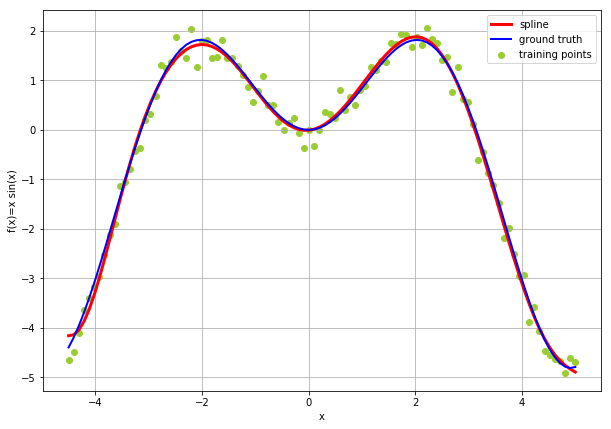

In [117]:
def g(x):
    return x*np.sin(x)

xx = np.linspace(-4.5, 5, 100)
x = np.linspace(-4.5, 5, 100)
y = g(x) + np.random.normal(0,1,100)*0.2

n=100
p =12
m= 4
lam = 0.0025

v = myspline(n,p,m)[0]
f = myspline(n,p,m)[1]
s = myspline(n,p,m)[2]
V = myspline(n,p,m)[3]
S = spl()

def f(x):
    l = 0
    for i in range (p):
        l = l + S[i]* B(x, m, i, t)
    return l

fig, ax = plt.subplots(figsize=[10, 7])
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
ax.plot(xx, [f(x) for x in xx], 'red', lw=3, label = 'spline')
ax.plot (xx, [g(x) for x in xx], 'blue', lw=2, label = "ground truth")  
ax.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)=x sin(x)')
plt.legend(loc='best')

# Пример
# $x - \sin(x)$


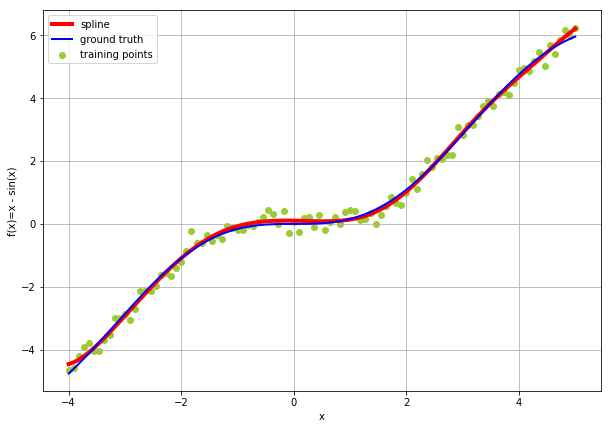

In [118]:
def g(x):
    return x - np.sin(x)

xx = np.linspace(-4, 5, 100)
x = np.linspace(-4, 5, 100)
y = g(x) + np.random.normal(0,1,100)*0.2
n=100
p =13
m= 4
lam = 0.0025

v = myspline(n,p,m)[0]
f = myspline(n,p,m)[1]
s = myspline(n,p,m)[2]
V = myspline(n,p,m)[3]
S = spl()

def f(x):
    l = 0
    for i in range (p):
        l = l + S[i]* B(x, m, i, t)
    return l

fig, ax = plt.subplots(figsize=[10, 7])
plt.scatter(x, y, color = 'yellowgreen', marker='o', label="training points")
ax.plot(xx, [f(x) for x in xx], 'red', lw=4, label = 'spline')
ax.plot (xx, [g(x) for x in xx], 'blue', lw=2, label = "ground truth")  
ax.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)=x - sin(x)')
plt.legend(loc='best')

# Сравним время работы для вычисления коэффициентов

## в 80 точках вычисляем коэффициенты при различных $\lambda$ 100 раз

In [87]:
import time

def g(x):
    return x - np.sin(x)

tim1 = [0]*100
i=0
xxx=[0]*100
p=13
m=4

for n in range (20,100):
    start_time = time.time() #засекаем время
    x = np.linspace(-5, 5, n)
    y = g(x) + np.random.normal(0,1,n)*0.2
    for lam in range (1,100):
        S = spline(n,p,m,lam)
    tim1[i] = (time.time() - start_time) #конец засекания
    xxx[i] = i
    i=i+1

In [123]:
import time
tim2 = [0]*100
k=0

def g(x):
    return x - np.sin(x)

xx=[0]*100

for n in range (20,100):

    start_time = time.time() #засекаем время
    x = np.linspace(-4, 5, n)
    y = g(x) + np.random.normal(0,1,n)*0.2
    v1 = myspline(n,p,m)[0]
    f1 = myspline(n,p,m)[1]
    s1 = myspline(n,p,m)[2]
    V1 = myspline(n,p,m)[3]
    p=13
    m=4

    for lam in range (1,100):
        v = v1
        f = f1
        s = s1
        V1 = V1
        S = spl()
    tim2[k] = (time.time() - start_time) #конец засекания
    xx[k] = k
    k=k+1

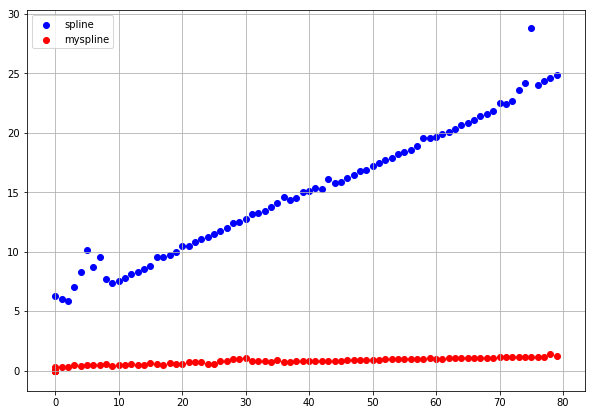

In [124]:
fig, ax = plt.subplots(figsize=[10, 7])
#plt.yscale('log')
#plt.xscale('log')
plt.scatter(xxx, tim1, color = 'blue', marker='o', label="spline")
plt.scatter(xx, tim2, color = 'red', marker='o', label="myspline")
plt.xlabel('number of points')
plt.ylabel('time')
ax.grid(True)
plt.legend(loc='best')

In [ ]:
import time

def g(x):
    return x - np.sin(x)

tim1 = [0]*100
i=0
xxx=[0]*100
p=13
m=4

for n in range (20,100):
    start_time = time.time()
    x = np.linspace(-5, 5, n)
    y = g(x) + np.random.normal(0,1,n)*0.2
    for lam in range (1,100):
        S = spline(n,p,m,lam)
    tim1[i] = (time.time() - start_time)
    xxx[i] = i
    i=i+1

In [60]:
import time
tim2 = [0]*100
k=0
n=100

def g(x):
    return x - np.sin(x)

for n in range (20,100):

    start_time = time.time() #засекаем время
    x = np.linspace(-4, 5, n)
    y = g(x) + np.random.normal(0,1,n)*0.2
    v1 = myspline(n,p,m)[0]
    f1 = myspline(n,p,m)[1]
    s1 = myspline(n,p,m)[2]
    V1 = myspline(n,p,m)[3]
    p=13
    m=4

    for lam in range (1,10000):
        v = v1
        f = f1
        s = s1
        V1 = V1
        S = spl()
    tim2[i] = (time.time() - start_time) #конец засекания
    k=k+1

## в 80 точках вычисляем коэффициенты при различных $\lambda$ 100 раз